In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data loaded successfully.
Class distribution before SMOTE:
Class
0    284315
1       492
Name: count, dtype: int64


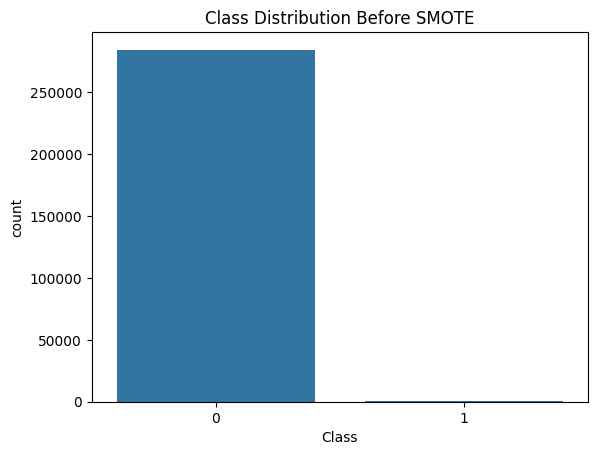

Class distribution after SMOTE:
Class
0    227451
1    113725
Name: count, dtype: int64


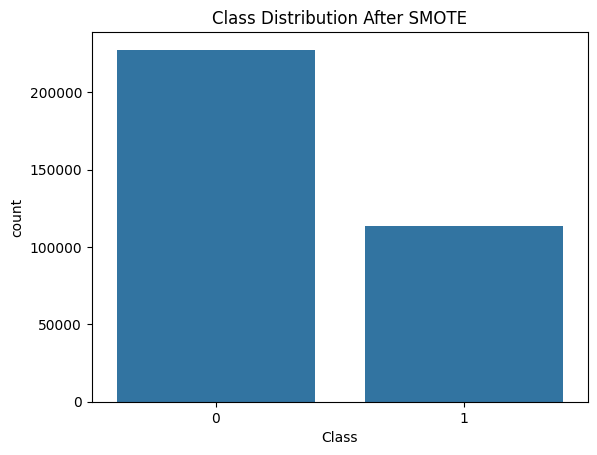

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:28:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Logistic Regression AUC: 0.9681
Random Forest AUC: 0.9795
XGBoost AUC: 0.9809
The best model is: XGBoost


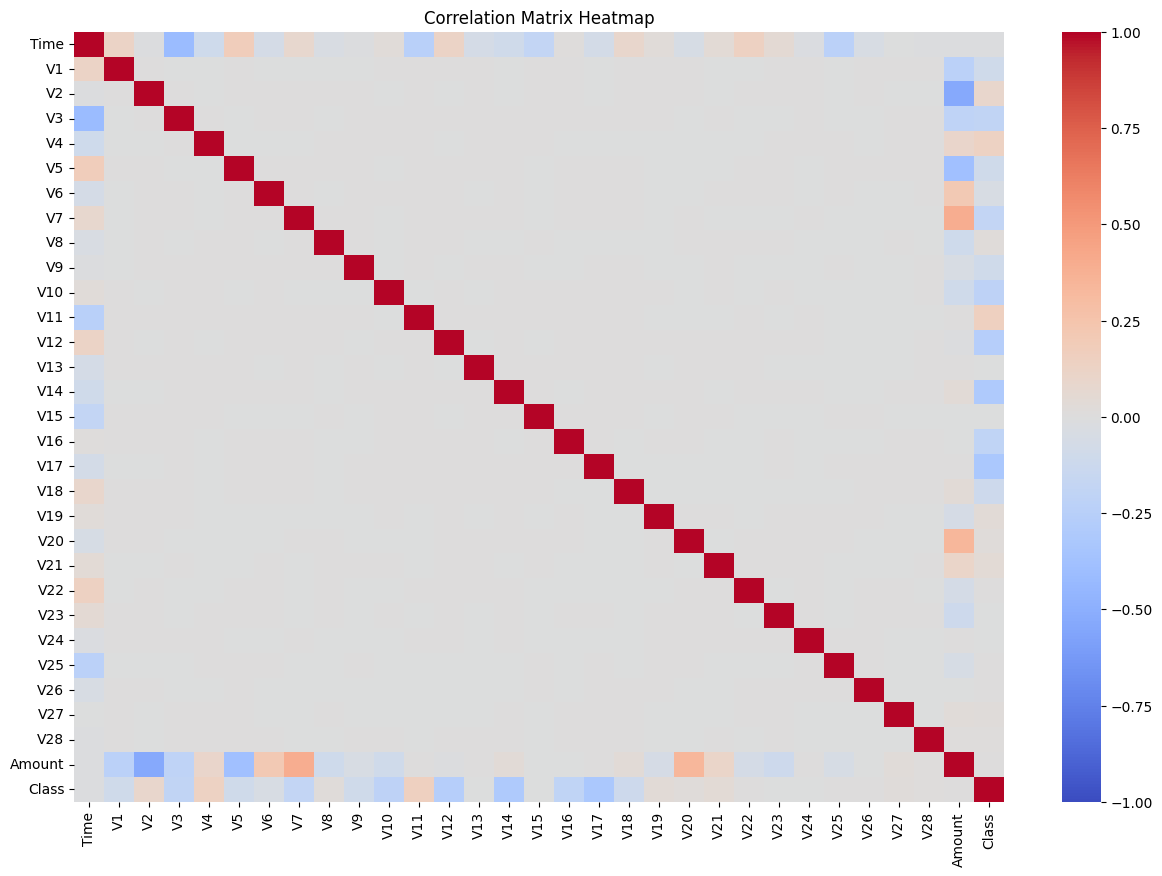

Logistic Regression Classification Report:
Class     Precision   Recall      F1-Score    Support
Class 0   0.9998      0.9869      0.9933      56864.0
Class 1   0.1059      0.8980      0.1895      98.0


Random Forest Classification Report:
Class     Precision   Recall      F1-Score    Support
Class 0   0.9998      0.9990      0.9994      56864.0
Class 1   0.6043      0.8571      0.7089      98.0


XGBoost Classification Report:
Class     Precision   Recall      F1-Score    Support
Class 0   0.9998      0.9992      0.9995      56864.0
Class 1   0.6462      0.8571      0.7368      98.0




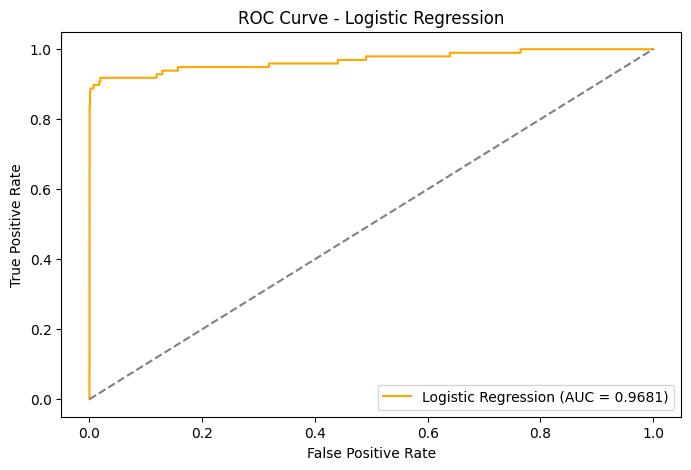

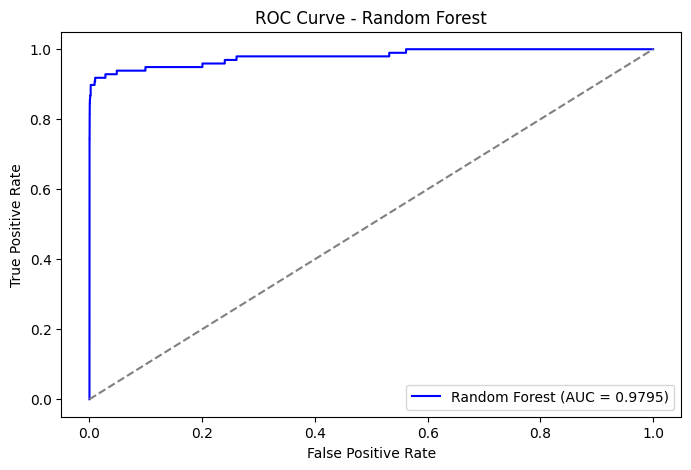

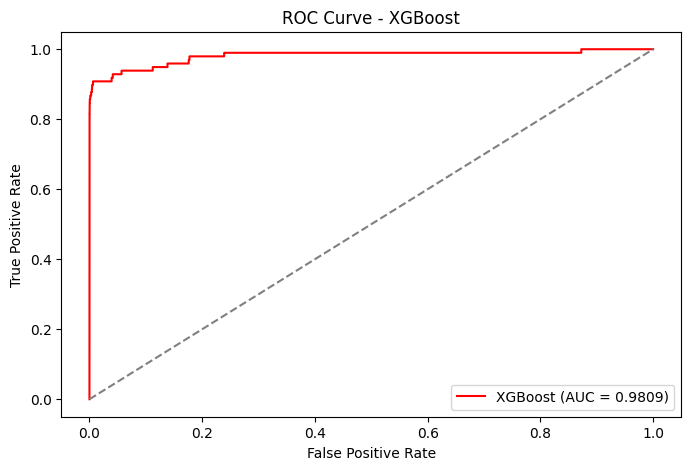

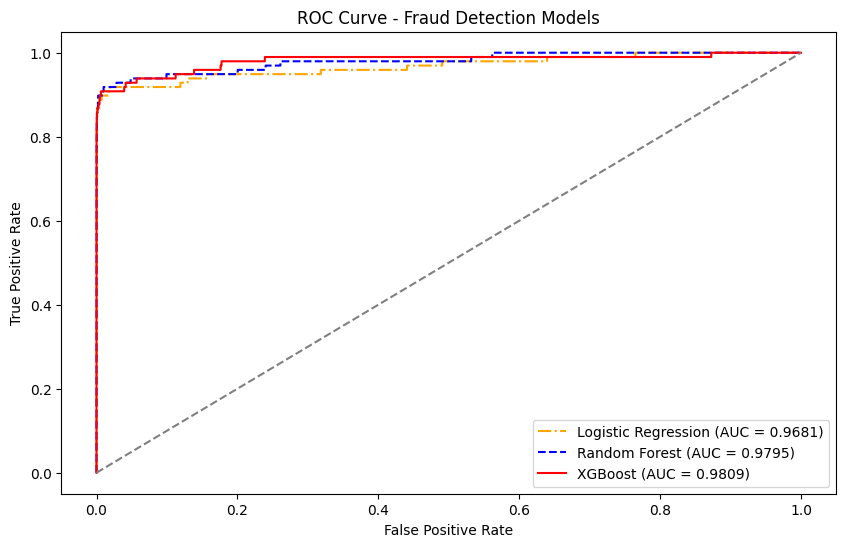

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

# Load Dataset
data = pd.read_csv("/content/creditcard.csv", on_bad_lines='skip')
print("Data loaded successfully.")

# Drop rows where 'Class' is NaN
data = data.dropna(subset=['Class'])

# Display class distribution before SMOTE
print("Class distribution before SMOTE:")
print(data['Class'].value_counts())

sns.countplot(x=data['Class'])
plt.title("Class Distribution Before SMOTE")
plt.show()

# Separate features and target
X = data.drop(columns=['Class'])
y = data['Class']

# Ensure no NaN values in features
X = X.fillna(X.median())

# Scale 'Time' and 'Amount'
scaler = StandardScaler()
X[['Time', 'Amount']] = scaler.fit_transform(X[['Time', 'Amount']])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Address imbalance using SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Display class distribution after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

sns.countplot(x=y_train_resampled)
plt.title("Class Distribution After SMOTE")
plt.show()

# Train Logistic Regression Model
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_resampled, y_train_resampled)
y_prob_log = logreg.predict_proba(X_test)[:, 1]
log_auc = round(roc_auc_score(y_test, y_prob_log), 4)

# Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
rf_auc = round(roc_auc_score(y_test, y_prob_rf), 4)

# Train XGBoost Model
xgb_model = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
xgb_auc = round(roc_auc_score(y_test, y_prob_xgb), 4)

# Compare Models
print("Logistic Regression AUC:", log_auc)
print("Random Forest AUC:", rf_auc)
print("XGBoost AUC:", xgb_auc)

best_model = "XGBoost" if xgb_auc > max(log_auc, rf_auc) else ("Random Forest" if rf_auc > log_auc else "Logistic Regression")
print(f"The best model is: {best_model}")

# Correlation Heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(data.corr(), cmap='coolwarm', annot=False, fmt='.2f', vmin=-1.0, vmax=1.0)
plt.title('Correlation Matrix Heatmap')
plt.show()


# Logistic Regression Classification Report
y_pred_log = logreg.predict(X_test)
logreg_report = classification_report(y_test, y_pred_log, target_names=['Class 0', 'Class 1'], output_dict=True)

# Random Forest Classification Report
y_pred_rf = rf_model.predict(X_test)
rf_report = classification_report(y_test, y_pred_rf, target_names=['Class 0', 'Class 1'], output_dict=True)

# XGBoost Classification Report
y_pred_xgb = xgb_model.predict(X_test)
xgb_report = classification_report(y_test, y_pred_xgb, target_names=['Class 0', 'Class 1'], output_dict=True)

# Print results in a structured manner
def print_report(model_name, report):
    print(f"{model_name} Classification Report:")
    print(f"{'Class':<10}{'Precision':<12}{'Recall':<12}{'F1-Score':<12}{'Support'}")
    for label, metrics in report.items():
        if label not in ['accuracy', 'macro avg', 'weighted avg']:  # Skip non-class rows
            print(f"{label:<10}{metrics['precision']:<12.4f}{metrics['recall']:<12.4f}{metrics['f1-score']:<12.4f}{metrics['support']}")
    print("\n")

# Display the classification reports for each model
print_report("Logistic Regression", logreg_report)
print_report("Random Forest", rf_report)
print_report("XGBoost", xgb_report)



# Separate ROC Curve Visualizations
plt.figure(figsize=(8, 5))
log_fpr, log_tpr, _ = roc_curve(y_test, y_prob_log)
plt.plot(log_fpr, log_tpr, label=f'Logistic Regression (AUC = {log_auc})', color='orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
rf_fpr, rf_tpr, _ = roc_curve(y_test, y_prob_rf)
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, y_prob_xgb)
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc})', color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend()
plt.show()

# Combined ROC Curve for Comparison
plt.figure(figsize=(10, 6))
plt.plot(log_fpr, log_tpr, label=f'Logistic Regression (AUC = {log_auc})', linestyle='-.', color='orange')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc})', linestyle='--', color='blue')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc})', linestyle='-', color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Fraud Detection Models')
plt.legend()
plt.show()
